In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

%matplotlib inline

db_file = r'datasets/database.sqlite'
engine = create_engine(r"sqlite:///{}".format(db_file))

In [2]:
sql = 'select member_id, loan_amnt, term, int_rate, installment,annual_inc, issue_d, loan_status, purpose, grade, sub_grade, \
zip_code, addr_state, dti, delinq_2yrs,mths_since_last_delinq,out_prncp, total_pymnt, total_pymnt_inv, total_rec_prncp,\
total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, \
last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, acc_now_delinq, tot_coll_amt, tot_cur_bal \
from loan where loan_status not in("Fully Paid","Does not meet the credit policy. Status:Fully Paid") and policy_code =1 \
and application_type = "INDIVIDUAL";'

df = pd.read_sql(sql,engine)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677160 entries, 0 to 677159
Data columns (total 33 columns):
member_id                      677160 non-null float64
loan_amnt                      677160 non-null float64
term                           677160 non-null object
int_rate                       677160 non-null object
installment                    677160 non-null float64
annual_inc                     677160 non-null float64
issue_d                        677160 non-null object
loan_status                    677160 non-null object
purpose                        677160 non-null object
grade                          677160 non-null object
sub_grade                      677160 non-null object
zip_code                       677160 non-null object
addr_state                     677160 non-null object
dti                            677160 non-null float64
delinq_2yrs                    677157 non-null float64
mths_since_last_delinq         339740 non-null float64
out_prncp         

In [4]:
df.corr().to_csv('loan_corr.csv')

In [5]:
# Loan Amount distribution by status
osloan_pt = pd.pivot_table(df,index=['loan_status'],values = 'loan_amnt',aggfunc='sum').sort_values(by='loan_amnt',ascending = False)

osloan_pt

,loan_amnt
loan_status,
Current,9.163969e+09
Charged Off,6.586432e+08
Late (31-120 days),1.804098e+08
Issued,1.279563e+08
In Grace Period,1.000256e+08
Late (16-30 days),3.693575e+07
Default,1.852130e+07
Does not meet the credit policy. Status:Charged Off,7.250225e+06


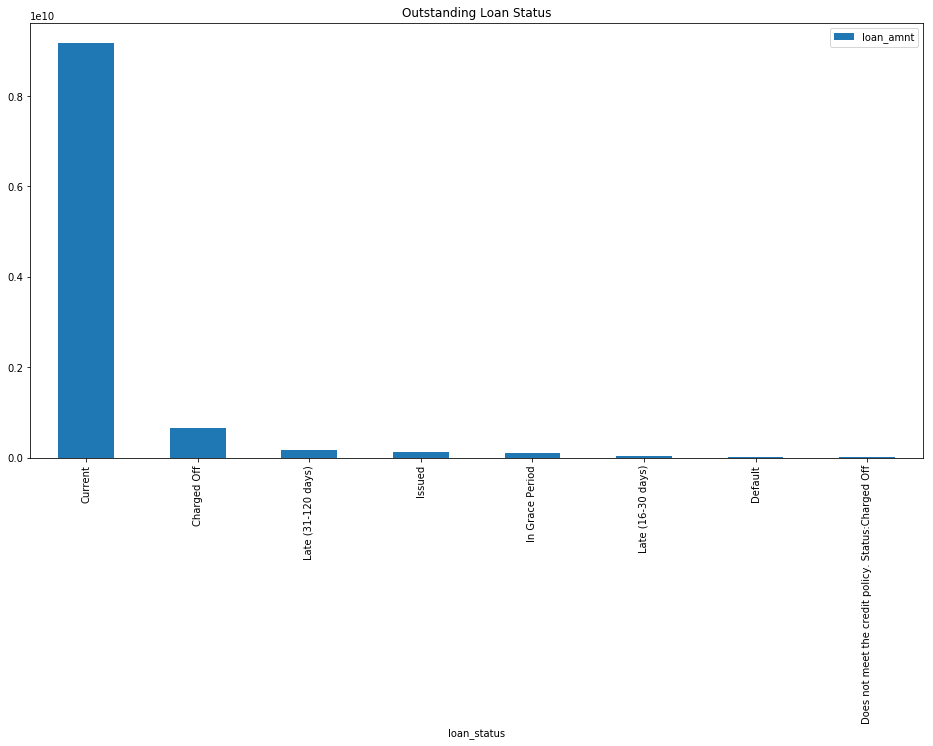

In [6]:
osloan_pt.plot(kind ='bar',figsize=(16,8),title='Outstanding Loan Status')

In [7]:
# Get Year from issue_dt & aggregate by state, year

df['issue_d'] = pd.to_datetime(df['issue_d'])
df['issue_yr'] = df['issue_d'].dt.year
os_pt = pd.pivot_table(df,index = ['addr_state','issue_yr'],values='loan_amnt',aggfunc='sum')
os_pt

loan_amnt
addr_state issue_yr             
AK         2008           5600.0
           2009          29325.0
           2010          24000.0
           2011         240800.0
           2012         586300.0
           2013        3678100.0
           2014        7955375.0
           2015       15556475.0
AL         2007           4200.0
           2008          42300.0
           2009          99275.0
           2010         152300.0
           2011        1007600.0
           2012        3309975.0
           2013       15124775.0
           2014       35861525.0
           2015       76452875.0
AR         2007            500.0
           2008           9150.0
           2009          27500.0
           2010         126200.0
           2011         376275.0
           2012        1568050.0
           2013        8863725.0
           2014       20866825.0
           2015       43923350.0
AZ         2007          64500.0
           2008         143150.0
           2009         232225.0
           2010         367325.0
...                          ...
WA         2007          15450.0
           2008         144050.0
           2009         161650.0
           2010         564650.0
           2011        1663325.0
           2012        4181700.0
           2013       28606000.0
           2014       57869925.0
           2015      129611075.0
WI         2008          14525.0
           2009          85000.0
           2010         301525.0
           2011         962600.0
           2012        2488800.0
           2013       14845100.0
           2014       34812775.0
           2015       78195100.0
WV         2009          42300.0
           2010          46450.0
           2011         347075.0
           2012         730050.0
           2013        6198325.0
           2014       15660675.0
           2015       28407200.0
WY         2010           6000.0
           2011         140000.0
           2012         407675.0
           2013        3134350.0
           2014        6719600.0
           2015       13023400.0

[388 rows x 1 columns]

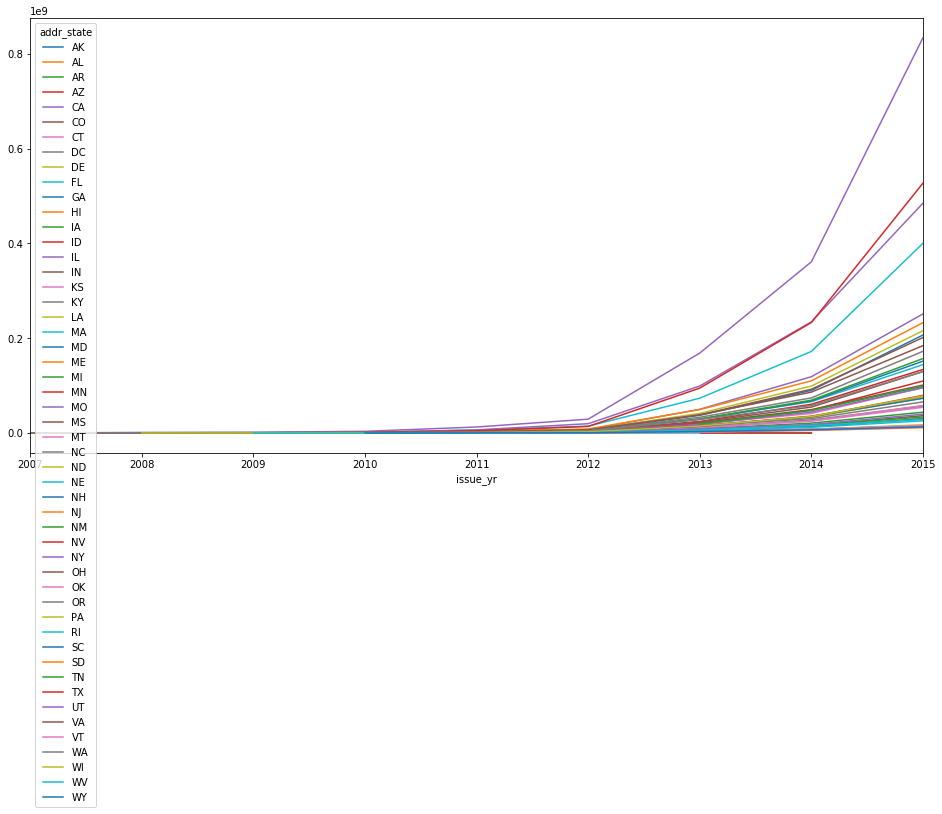

In [8]:
# Plotting yearly loan amount distribution for each state

fig = df.groupby(['issue_yr','addr_state'])['loan_amnt'].sum().unstack().plot(figsize=(16,8))


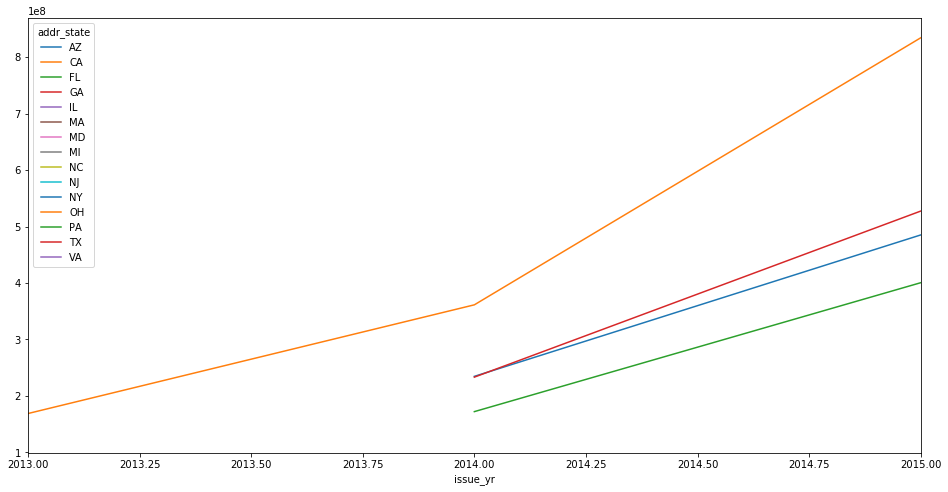

In [9]:
# Plotting yearly loan amount distribution for each state

fig_top20 = df.groupby(['issue_yr','addr_state'])['loan_amnt'].sum().sort_values(ascending=False).head(20).unstack().plot(figsize=(16,8))

In [10]:
df_top20 = df.groupby(['issue_yr','addr_state'])['loan_amnt'].sum().sort_values(ascending=False).head(20)
df_top20

issue_yr  addr_state
2015      CA            834363750.0
          TX            527416675.0
          NY            485125625.0
          FL            400516250.0
2014      CA            361327450.0
2015      IL            251404150.0
2014      NY            234599375.0
          TX            233249575.0
2015      NJ            232979200.0
          PA            215964200.0
          GA            206803725.0
          OH            201488850.0
          VA            184367025.0
          NC            172401125.0
2014      FL            172158000.0
2013      CA            168767700.0
2015      MI            157170250.0
          MD            151720400.0
          MA            144251450.0
          AZ            134066300.0
Name: loan_amnt, dtype: float64

In [11]:
# Identifying Bad Debt

bad_indicators = ['Default','Does not meet the credit policy. Status:Charged Off','Charged Off']
      
df['bad_loan'] = 0
df.loc[df.loan_status.isin(bad_indicators),'bad_loan']=1
df.head()

,member_id,loan_amnt,term,int_rate,installment,annual_inc,issue_d,loan_status,purpose,grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,issue_yr,bad_loan
0,1314167.0,2500.0,60 months,15.27%,59.83,30000.0,2011-12-01,Charged Off,car,C,...,119.66,None,Sep-2013,0.0,NaN,0.0,NaN,NaN,2011,1
1,1311748.0,3000.0,60 months,12.69%,67.79,80000.0,2011-12-01,Current,other,B,...,67.79,Feb-2016,Jan-2016,0.0,NaN,0.0,NaN,NaN,2011,0
2,1304742.0,7000.0,60 months,15.96%,170.08,47004.0,2011-12-01,Current,debt_consolidation,C,...,170.08,Feb-2016,Jan-2016,0.0,NaN,0.0,NaN,NaN,2011,0
3,1306957.0,5600.0,60 months,21.28%,152.39,40000.0,2011-12-01,Charged Off,small_business,F,...,152.39,None,Aug-2012,0.0,NaN,0.0,NaN,NaN,2011,1
4,1306721.0,5375.0,60 months,12.69%,121.45,15000.0,2011-12-01,Charged Off,other,B,...,121.45,None,Mar-2013,0.0,NaN,0.0,NaN,NaN,2011,1


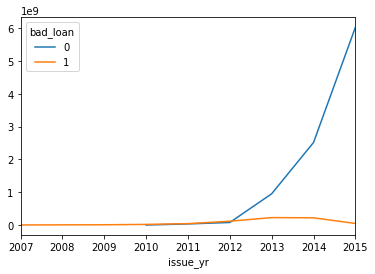

In [12]:
# Plotting yearly bad debt 
df.groupby(['issue_yr','bad_loan'])['loan_amnt'].sum().unstack().plot()

In [13]:
df_badloans = df[df['bad_loan']==1]
df_badloans 

#probablibility of bad debt
p_baddebt = 100*(df[df['bad_loan']==1]['member_id'].count())/(df['bad_loan'].count())
p_baddebt

6.974422588457676

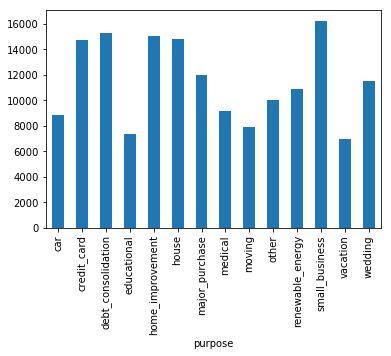

In [14]:
# Bad Debt distribution over purpose
# Ratio of bad debt to total loan

df_badloans.groupby('purpose')['loan_amnt'].mean().plot(kind='bar')

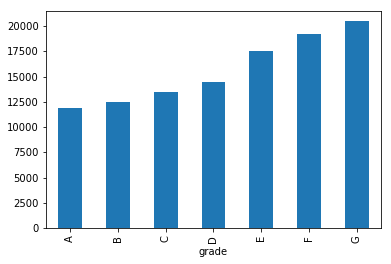

In [15]:
# Bad Debt distribution over grade
# Ratio of Bad Debt to total loan by grade

df_badloans.groupby('grade')['loan_amnt'].mean().plot(kind='bar')

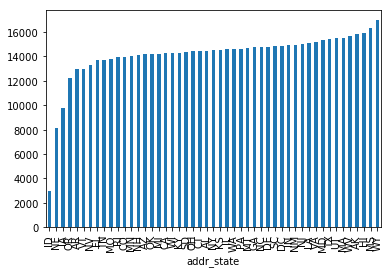

In [16]:
# Bad Debt distribution over state
# Ratio of Bad Debt to total loan by state

df_badloans.groupby('addr_state')['loan_amnt'].mean().sort_values().plot(kind='bar')

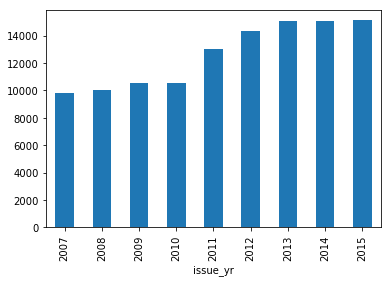

In [17]:
# Bad Debt distribution over year
# Ratio of Bad Debt to total loan by year

df_badloans.groupby('issue_yr')['loan_amnt'].mean().plot(kind='bar')